# ART Sampler

ART stands for A Reconstruction Tool, and the ART Sampler is a probability sampler that uses Gaussian process reconstruction to achieve its goal. Upon completion, the ART Sampler provides an approximated reconstruction of the probability surface given an initial log-posterior probability function. It will also contain MCMC chains (produced using `emcee`).

This notebook will demonstrate how to use the ART Sampler on an extremely simple example problem for which we know the answer exactly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ARTsampler
import scipy.stats
%matplotlib inline

In [2]:
#Plot configurations
plt.rc("text", usetex=True)
plt.rc("font", size=24, family="serif")

## Step 0: define a true distribution
We will start with a simple example - a 2D Gaussian distribution.

Our target distribution needs a log-likelihood. We will assume a flat prior so that the posterior is just the likelihood. In this really silly example, the likelihood knows the true mean and covariance, but in a real analysis there would be some kind of model involved.

In a real analysis, the only thing required would be to assemble the `args` dictionary and define the likelihood.

Text(0, 0.5, '$y$')

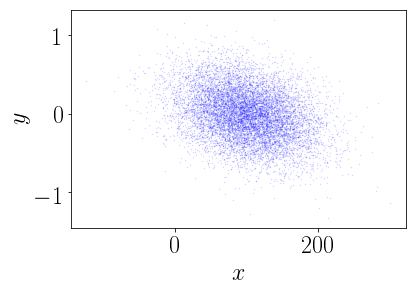

In [3]:
#True mean and covariance
true_means = np.array([100.0, 0.0])
stddevs = np.array([50.0, 0.1]) #standard deviations
rho = -0.99 #correlation
true_cov = np.array([[stddevs[0]**2, rho*stddevs[0]*stddevs[1]],
                    [rho*stddevs[0]*stddevs[1], stddevs[1]]])

#Plot a bunch of samples
true_samples = np.random.multivariate_normal(mean=true_means, cov=true_cov, size=10000).T
plt.scatter(true_samples[0], true_samples[1], marker='.', c='b', alpha=0.2, s=0.5)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

In [4]:
#Assemble an arguments dictionary for the log-likelihood
loglike_args = {"true_mean": true_means, "true_covariance": true_cov}

def true_log_likelihood(params, args):
    #Params is a 2D array containing the two parameters (labeled x and y in figures)
    mu = args["true_mean"]
    C = args["true_covariance"]
    D = mu - params
    return -0.5 * np.dot(D, np.linalg.solve(C, D))

## Step 1: define the prior distributions and make an ARTsampler object
The first step for the reconstruction sampler is to define the prior distributions. From here we can create the sampler object.

In [5]:
#The prior volume should be an Ndim x 2 array containing the lower and upper bounds
#of the volume to be probed for each parameter.
#Perhaps later we can deal with more complex prior volume shapes
prior_distributions = [scipy.stats.uniform(loc=-300, scale=700), 
                       scipy.stats.uniform(loc=-12, scale=22)]

In [6]:
sampler = ARTsampler.ARTsampler(prior_distributions, true_log_likelihood, 
                                loglike_args, quiet=False, 
                                Ntraining_points=100, Nburn = 200, Nsteps=1000)

Maximizing True lnprob:
 final_simplex: (array([[ 1.00000005e+02, -1.33617016e-07],
       [ 9.99999323e+01,  7.63350748e-08],
       [ 9.99999464e+01,  4.35623326e-07]]), array([8.98073677e-14, 9.35158993e-13, 1.17619761e-12]))
           fun: 8.980736771014392e-14
       message: 'Optimization terminated successfully.'
          nfev: 105
           nit: 55
        status: 0
       success: True
             x: array([ 1.00000005e+02, -1.33617016e-07])


Let's now plot the current training points in comparison to the truth samples.

Text(0, 0.5, '$y$')

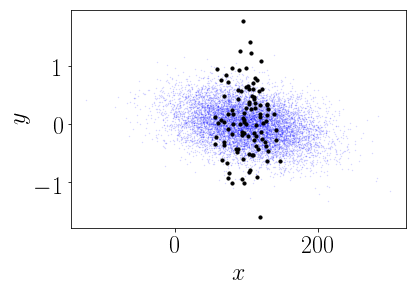

In [7]:
training_points = sampler.get_training_points()
#print(training_points.shape)
#print(training_points)
plt.scatter(training_points[:,0], training_points[:,1], c='k', s=10, zorder=1)

plt.scatter(true_samples[0], true_samples[1], marker='.', c='b', alpha=0.2, s=0.5, zorder=0)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
#plt.savefig("initial_points.png", dpi=300, bbox_inches="tight")

# Step 2: iterate until we hit the maximum number of iterations (2)
The default maximum number of iterations is two. Let's iterate until we are done.

In [8]:
i = 0
while sampler.single_iteration():
    print("On iteration {0}".format(i))
    i+=1
    continue

Performing iteration 0
Computing log-probability of training points.
Reconstructing the distribution
      fun: 6547.80896314991
 hess_inv: array([[7.76126341e-05]])
      jac: array([-0.01922607])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 4
     njev: 26
   status: 2
  success: False
        x: array([1.9920587])
Running first burn-in
Running second burn-in
Running production...
On iteration 0
Performing iteration 1
Computing log-probability of training points.
Reconstructing the distribution
      fun: 7775.246222733802
 hess_inv: array([[0.00010605]])
      jac: array([0.03320312])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 48
      nit: 6
     njev: 37
   status: 2
  success: False
        x: array([2.94066307])
Running first burn-in
Running second burn-in
Running production...
On iteration 1
Performing iteration 2
Computing log-probability of training points.
Reconstructing the dis

# Step 3: analyze everything
We can do things like make corner plots now.

Text(0, 0.5, '$y$')

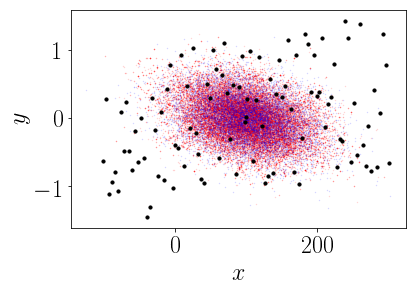

In [9]:
training_points = sampler.get_training_points()
plt.scatter(training_points[:,0], training_points[:,1], c='k', s=10, zorder=1)

samples = sampler.get_samples().T
plt.scatter(samples[0], samples[1], marker='.', c='r', alpha=0.2, s=0.5, zorder=0)

plt.scatter(true_samples[0], true_samples[1], marker='.', c='b', alpha=0.2, s=0.5, zorder=0)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
#plt.savefig("truth_vs_artsamples_and_training_points.png", dpi=300, bbox_inches="tight")

Text(0, 0.5, '$y$')

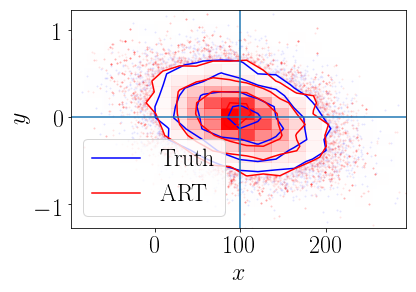

In [10]:
import corner
corner.hist2d(true_samples[0], true_samples[1], color='b', plot_datapoints=1)
corner.hist2d(samples[0], samples[1], color='r', plot_datapoints=1)
plt.plot([], [], color='b',  label="Truth")
plt.plot([], [], color='r',  label="ART")
plt.axvline(true_means[0])
plt.axhline(true_means[1])
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
#plt.savefig("truth_vs_art.png", dpi=300, bbox_inches="tight")